In [87]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
from imblearn.under_sampling import RandomUnderSampler
import pickle

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [2]:
!pip install imblearn

In [5]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [6]:
data = pd.read_csv('data/crap.csv')

In [7]:
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)

In [8]:
data['target'] = data['target'].astype(int)

In [9]:
def get_data(data, features, target):
    df_X = data[features]
    df_y = data[target]
    
    rus = RandomUnderSampler(random_state=42)
    Xus, yus = rus.fit_resample(df_X, df_y)
    
    print(len(Xus),len(yus))
    
    X_train, X_test, y_train, y_test = train_test_split(Xus, yus, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)
    

    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

   
    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)
    
    print(y_np_test.sum(), len(y_np_test)-y_np_test.sum())

    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

#     test_population =  torch.from_numpy(np.array(X_test['TotalPop'])).type(torch.float32)
    return X_nuts_train, y_nuts_train, X_nuts_test, y_nuts_test


In [10]:
bool_split = 3
offset = 3

In [11]:
def sep_data(row):
    if row['target'] >= bool_split + offset :
        return 1
    elif row['target'] <= bool_split - offset :
        return 0
    else:
        return float('nan')

In [12]:
data.columns

Index(['Unnamed: 0', 'month', 'CensusTract', 'TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'FELONY', 'MISDEMEANOR',
       'VIOLATION', 'restaurants', 'bar', 'park', 'subway_station', 'target'],
      dtype='object')

In [13]:
features = ['TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment','restaurants', 'bar', 'park', 'subway_station']
target = 'binary_target'            

In [ ]:
# for bool_split in range(2,10):
#     for offset in range(1,5):

bool_split = 5
offset = 2

for bool_split in range(2,20):
    for offset in range(1,10):
        if bool_split - offset <= 0:
            continue
        print(bool_split, offset)
        data_new = deepcopy(data)
        data_new['binary_target'] = data_new.apply(sep_data, axis=1)
        data_new = data_new.dropna()
#         print(len(data_new[data_new['binary_target']==0]), len(data_new[data_new['binary_target']==1]))
        if (len(data_new[data_new['binary_target']==0]) == 0) or (len(data_new[data_new['binary_target']==1]) == 0):
            print('-'*30)
            continue
        X_nuts_train, y_nuts_train, X_nuts_test, y_nuts_test = get_data(data_new, features, target)
        reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
        print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
        print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
        print('-'*30)

        

# SVI

In [15]:
bool_split = 9
offset = 5


data_new = deepcopy(data)
data_new['binary_target'] = data_new.apply(sep_data, axis=1)
data_new = data_new.dropna()
X_nuts_train, y_nuts_train, X_nuts_test, y_nuts_test = get_data(data_new, features, target)


1598 1598
158.0 162.0


In [1]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics
import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy

from torch.distributions import constraints
from pyro.infer.autoguide.initialization import init_to_mean

from sklearn.metrics import accuracy_score


pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [47]:
def model_1(data_x, data_y, D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 1.)))
            
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_x)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    return p 


def guide_1(data_x, data_y, D):
    
    mu_i = []
    sigma_i = []
    for i in range(D+1):
        mu_i.append(pyro.param('mu_i'+str(i),torch.tensor(0.),constraint = constraints.real))
        sigma_i.append(pyro.param('sigma_i'+str(i),torch.tensor(1.), constraint = constraints.positive))
    
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(mu_i[i], sigma_i[i])))
        

    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]

    
    p = 1. / (1 + torch.exp(-logit))


In [48]:
svi = SVI(model_1, 
          guide_1, 
          optim.Adam({"lr": 5e-2}), 
          loss=Trace_ELBO(), 
          num_samples=2000)

pyro.clear_param_store()
elbo_arr_1 = []
for i in range(5000):
    elbo = svi.step(X_nuts_train, y_nuts_train, X_nuts_train.shape[1])
    elbo_arr_1.append(elbo)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 947.0158081054688
Elbo loss: 728.0423904657364
Elbo loss: 713.1913037896156
Elbo loss: 711.739469319582
Elbo loss: 716.0943340063095
Elbo loss: 709.0993185043335
Elbo loss: 715.4851067662239
Elbo loss: 713.6819304227829
Elbo loss: 716.345874607563
Elbo loss: 711.9123081564903


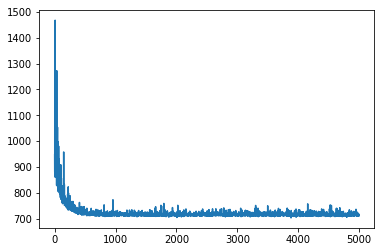

In [49]:
plt.plot(elbo_arr_1)

In [50]:
def predict(x):
    model_preds = []
    for i in range(len(x)):
        guide_trace = pyro.poutine.trace(guide).get_trace(x,None,x.shape[1])
        replay_result = pyro.poutine.replay(model, guide_trace)(x,None,x.shape[1])
        model_preds.append(replay_result.detach().numpy())
    return model_preds

In [51]:
ypred_1 = predict(X_nuts_test)
# accuracy_score(ypred, y_nuts_test)


In [60]:
preds_1 = []
for i in range(320):
    preds_1.append(1 if ypred_1[i][i]>=0.5 else 0)
acc = accuracy_score(preds_1,y_nuts_test)

In [61]:
acc

0.725

In [62]:
p = ypred_1
for i in range(len(p)):
    for j in range(len(p[0])):
        p[i][j] = 0 if p[i][j] < 0.5 else 1
preds_1 = np.sum(p, axis=0)
test_size = len(p[0])
preds_1 = [p >= test_size/2 for p in preds_1]
accuracy_score(preds_1, y_nuts_test)


0.771875

## Model 2

In [40]:
def model_2(data_x, data_y, D):
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 1.)))
        
    sd_u = pyro.sample("sd_u",dist.Gamma(0.1,0.1))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0., sigma2_ui))
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_x)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    return p


def guide_2(data_x, data_y, D):
    
    mu_i = []
    sigma_i = []
    for i in range(D+1):
        mu_i.append(pyro.param('mu_i'+str(i),torch.tensor(0.),constraint = constraints.real))
        sigma_i.append(pyro.param('sigma_i'+str(i),torch.tensor(1.), constraint = constraints.positive))
    
    beta = []
    for i in range(D+1):
#         print(mu_i[i],sigma_i[i])
        beta.append(pyro.sample("beta"+str(i), dist.Normal(mu_i[i], sigma_i[i])))     

    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    alpha_gamma = pyro.param('alpha_gamma',torch.tensor(0.1).type(torch.float32),constraint = constraints.positive)
    beta_gamma = pyro.param('beta_gamma',torch.tensor(0.1).type(torch.float32),constraint = constraints.positive)
      
    sd_u = min(pyro.sample("sd_u",dist.Gamma(alpha_gamma, beta_gamma)),500)
    sigma2_ui = 1/((sd_u+1)**2) 
#     print('sigma : ',sigma2_ui)
    u_i = pyro.sample("u_i",dist.Normal(0., sigma2_ui))
    
    
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))
    
    return p


In [41]:
bool_split = 9
offset = 5


data_new = deepcopy(data)
data_new['binary_target'] = data_new.apply(sep_data, axis=1)
data_new = data_new.dropna()
X_nuts_train, y_nuts_train, X_nuts_test, y_nuts_test = get_data(data_new, features, target)

pyro.clear_param_store()
svi = SVI(model_2, 
          guide_2, 
          optim.Adam({"lr": 5e-2}), 
          loss=Trace_ELBO(), 
          num_samples=20000)

pyro.clear_param_store()
elbo_arr_2 = []
for i in range(5000):
    elbo = svi.step(X_nuts_train, y_nuts_train, X_nuts_train.shape[1])
    elbo_arr_2.append(elbo)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

1598 1598
175.0 145.0
Elbo loss: 1329.345274925232
Elbo loss: 728.8950216770172
Elbo loss: 716.2777455449104
Elbo loss: 716.1204393208027
Elbo loss: 716.7133545875549
Elbo loss: 713.796742618084
Elbo loss: 721.302995622158
Elbo loss: 717.756269454956
Elbo loss: 726.9531638622284
Elbo loss: 717.47631290555


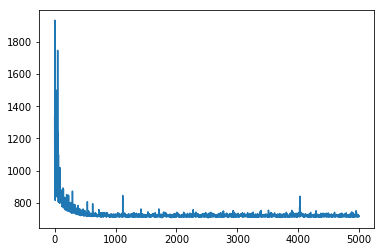

In [42]:
plt.plot(elbo_arr_2)

In [43]:
ypred_model_2 = predict(X_nuts_test)
# accuracy_score(ypred, y_nuts_test)
print(len(ypred_model_2))

preds = []
for i in range(320):
    preds.append(1 if ypred_model_2[i][i]>=0.5 else 0)
acc = accuracy_score(preds,y_nuts_test)

print(acc)

320
0.734375


In [45]:
p = ypred_model_2
for i in range(len(p)):
    for j in range(len(p[0])):
        p[i][j] = 0 if p[i][j] < 0.5 else 1
preds = np.sum(p, axis=0)
test_size = len(p[0])
preds = [p >= test_size/2 for p in preds]
accuracy_score(preds, y_nuts_test)


0.759375

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_nuts_test, preds))

              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       145
         1.0       0.83      0.70      0.76       175

    accuracy                           0.76       320
   macro avg       0.76      0.77      0.76       320
weighted avg       0.77      0.76      0.76       320



In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_nuts_test, preds_1))

              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76       145
         1.0       0.82      0.75      0.78       175

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.78      0.77      0.77       320



# ICAR MODEL

In [65]:
df = pd.read_csv("data/census_block_loc.csv")

Index(['Unnamed: 0', 'month', 'CensusTract', 'TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'FELONY', 'MISDEMEANOR',
       'VIOLATION', 'restaurants', 'bar', 'park', 'subway_station', 'target'],
      dtype='object')

In [66]:
df_flat_agg = deepcopy(data)
ct_set = set(list(df_flat_agg['CensusTract'].unique()))
df_census_block = pd.read_csv("data/census_block_loc.csv")
df_census_block['CensusTract'] = df_census_block.apply(lambda row : int(row['BlockCode'])//10000, axis=1)
df_census_block = df_census_block[df_census_block['CensusTract'].isin(ct_set)]
df_census_block = df_census_block[['Latitude','Longitude','CensusTract','BlockCode']]
df_census_block.to_csv('points.csv',index=False)

In [67]:
lats = df_census_block['Latitude']
longs = df_census_block['Longitude']

In [68]:
unique_lats = sorted(list(set(lats)))
len(unique_lats)

187

In [69]:
unique_longs = sorted(list(set(longs)))
len(unique_longs)

177

In [70]:
matr = np.zeros((len(unique_lats), len(unique_longs)))
pairs = set([(i,j) for (i,j) in zip(lats,longs)])
for lat_index, lat in enumerate(unique_lats):
    for long_index, lon in enumerate(unique_longs):
        if (lat, lon) in pairs:
            matr[lat_index][long_index] += 1


In [93]:
unique_tracts = 2078

In [94]:
c_tract_id =  pickle.load(open("c_tract_id.pkl", 'rb'))
c_id_tract = pickle.load(open("c_id_tract.pkl", 'rb'))

In [95]:
W = pickle.load(open("weight_matrix","rb"))

In [96]:
W.shape

(2078, 2078)

In [114]:
W_bakchod = deepcopy(W)
W_bakchod = np.tril(W_bakchod)
print(np.sum(W_bakchod),2078*2078)

for i in range(len(W)):
    W[i][i] = 0


9601.0 4318084


In [119]:
node1 = []
node2 = []

for i in range(len(W)):
    for j in range(i+1,len(W)):
        if W[i][j]==1:
            node1.append(i)
            node2.append(j)

In [120]:
(len(node1), len(node2))

(7523, 7523)

In [97]:
def get_data_icar(data, features, target):

    required#####
    one_table = data[data[target]==1]
    zero_table = data[data[target]==0]
    one_indices = len(one_table)
    zero_indices = len(zero_table)
    
    if one_indices < zero_indices:
        zero_table = zero_table.sample(one_indices)
    else:
        one_table = one_table.sample(zero_indices)
    
    table = one_table.append(zero_table, ignore_index=True)
    
    df_X = table[features]
    df_y = table[target]
    
    
        

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)
    

        

    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

    censor_ids =  torch.from_numpy(np.array(X_train['CensusIds'])).type(torch.int32)

    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)

    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

    test_censor_ids =  torch.from_numpy(np.array(X_test['CensusIds'])).type(torch.int32)
    
    return X_nuts_train, y_nuts_train, censor_ids, X_nuts_test, y_nuts_test, test_censor_ids


In [124]:
W = torch.from_numpy(np.array(W)).type(torch.int32)
D = torch.diag(torch.sum(W, axis=1) + 1).type(torch.int32)
Q = D - W

In [126]:
Q.shape

torch.Size([2078, 2078])

In [ ]:
def icar_model(data_x, data_y, node1, node2):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    #unstructured random noise
    sd_u = pyro.sample("sd_u",dist.Gamma(0.01,0.01))
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    
    #structured random noise
    sd_s = pyro.sample("sd_s",dist.Gamma(1.,1.))
    sigma2_si = 1/(sd_s**2) 
    
    phi = []
    for i in range(2078):
        phi.append(pyro.sample("phi"+str(i), dist.Normal(0.,1.)))
    phi.append(-torch.sum(phi))

    phi_joint = torch.exp(-0.5 * torch.dot(phi[node1] - phi[node2])) 
    
    logit += phi_joint*sigma2_si
        
        
    p = 1. / (1 + torch.exp(-logit)) 


    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
        
def icar_model(data_x, data_y, node1, node2):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    #unstructured random noise
    sd_u = pyro.sample("sd_u",dist.Gamma(0.01,0.01))
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    
    #structured random noise
    sd_s = pyro.sample("sd_s",dist.Gamma(1.,1.))
    sigma2_si = 1/(sd_s**2) 
    
    phi = []
    for i in range(2078):
        phi.append(pyro.sample("phi"+str(i), dist.Normal(0.,1.)))
    phi.append(-torch.sum(phi))

    phi_joint = torch.exp(-0.5 * torch.dot(phi[node1] - phi[node2])) 
    
    logit += phi_joint*sigma2_si
        
        
    p = 1. / (1 + torch.exp(-logit)) 


    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)

torch.Size([5])